In [6]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from gapt.constants import feature_list
from gapt.data import GapFillingDataset
from gapt.model import GapT
from gapt.baseline import Baseline

In [7]:
output_dir = 'results/baseline_avg_data_env'

# Load metadata
with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

# Extract arguments from metadata
args = metadata['args']

In [8]:
# Initialize model from checkpoint
model = Baseline.load_from_checkpoint(
    checkpoint_path=os.path.join(args['output_dir'], 'model.ckpt'),
    d_input=len(feature_list), 
    n_head=args['n_head'], 
    d_model=args['d_model'], 
    d_output=args['d_output'],
    learning_rate=args['learning_rate'],
    dropout_rate=args['dropout_rate'],
    optimizer=args['optimizer'],
    use_attention_mask=args['use_attention_mask'],
)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file results/baseline_avg_data_env/model.ckpt`


In [9]:
with open(os.path.join(args['data_dir'], 'paths.json'), 'r') as f:
    data_paths = json.load(f)

test_dataset = GapFillingDataset(data_paths['test'], metadata['feature_list'])

test_dataloader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

(120, 1)


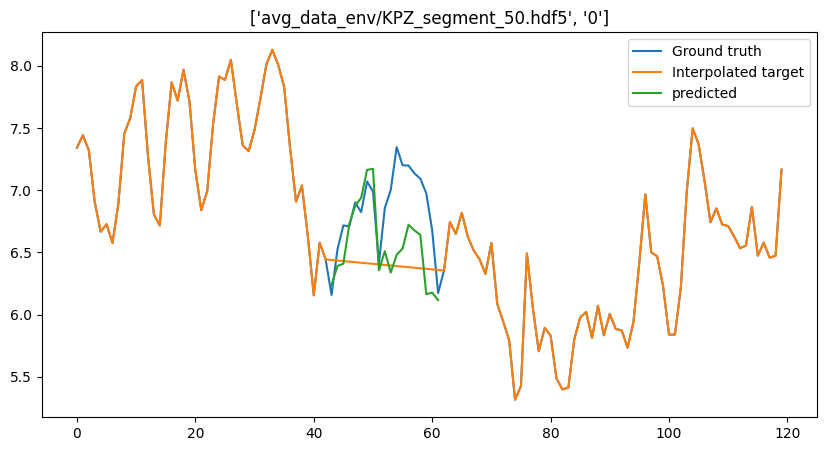

(120, 1)


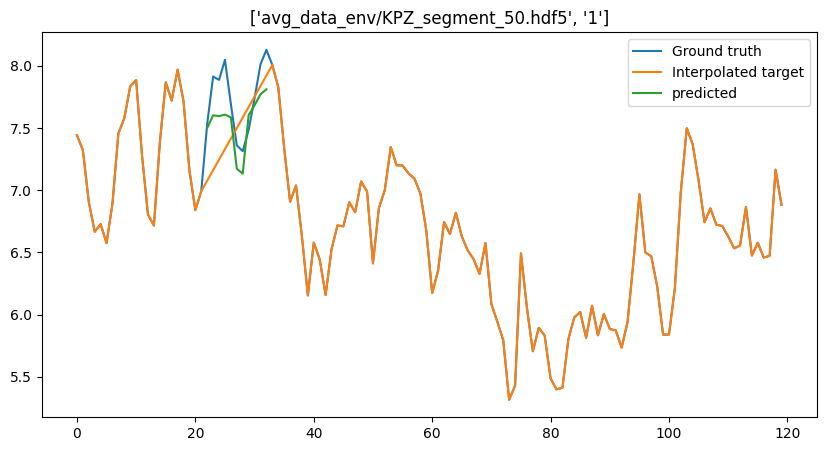

(120, 1)


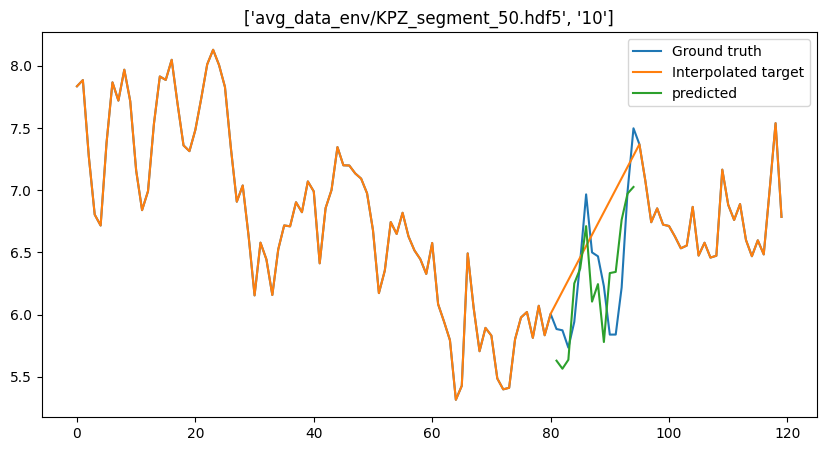

(120, 1)


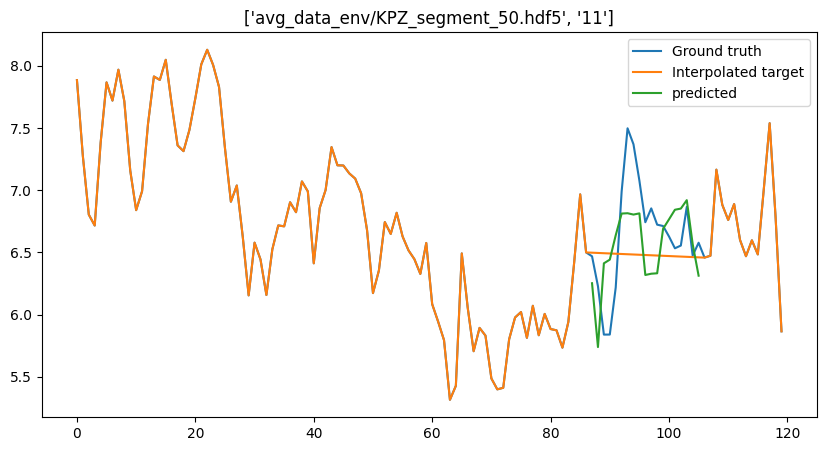

(120, 1)


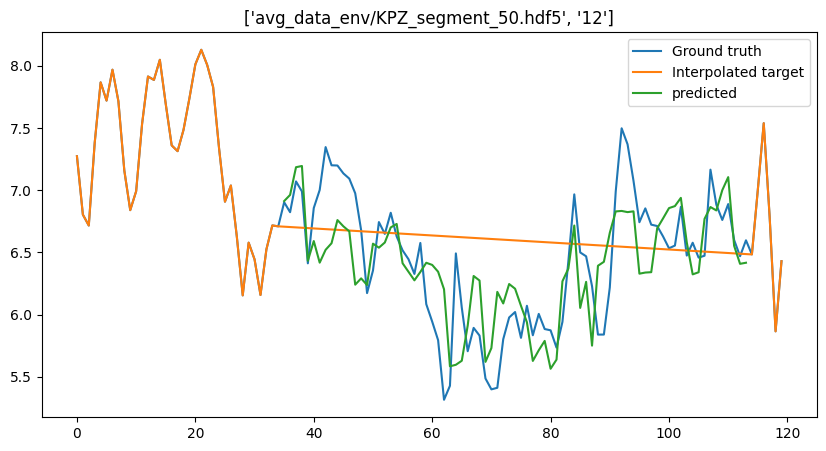

(120, 1)


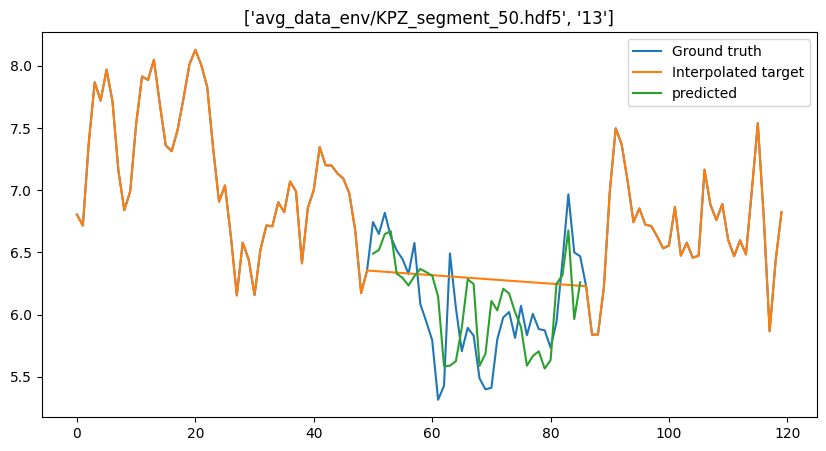

(120, 1)


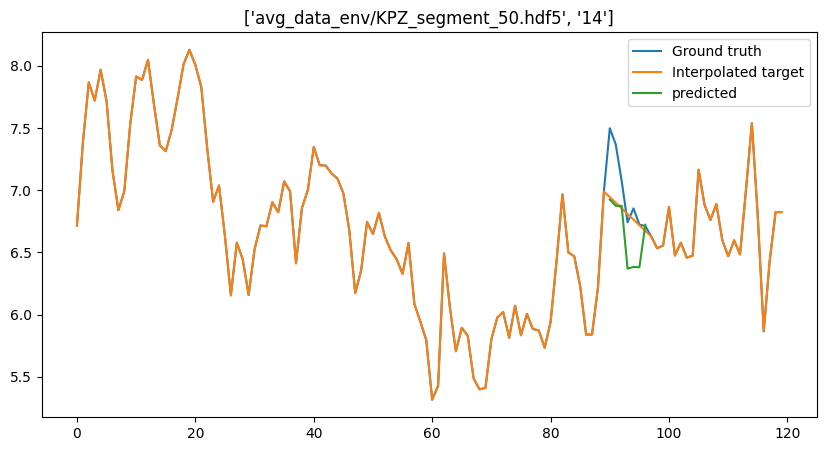

(120, 1)


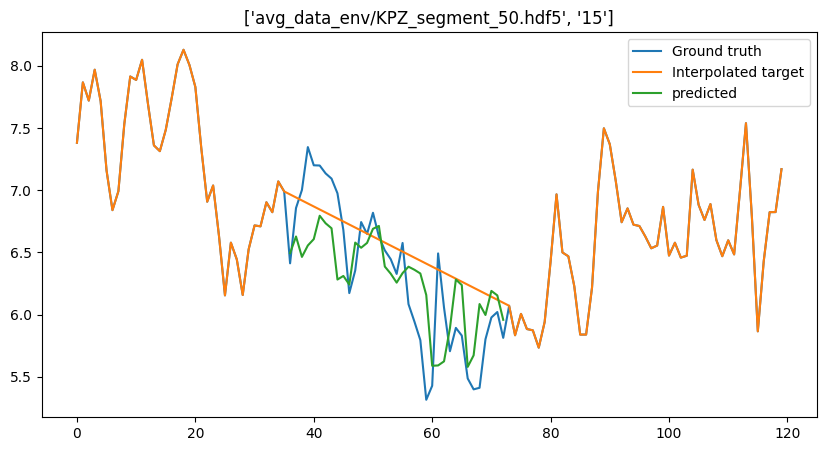

In [10]:
from sklearn.impute import KNNImputer

model.eval()

imputer = KNNImputer(n_neighbors=5, weights='distance')

for batch in test_dataloader:
    
    with torch.no_grad():
        predictions = model(batch)

    mask = batch['mask'].cpu().detach().numpy()
    target = batch['target'].cpu().detach().numpy()
    interpolated_target = batch['interpolated_target'].cpu().detach().numpy()
    predictions = predictions.cpu().detach().numpy()
    observations = batch['padded_observations'].cpu().detach().numpy()
    covariates = batch['covariates'].cpu().detach().numpy()

    for idx in range(0, 8):
        
        m = mask[idx]
        t = target[idx]
        it = interpolated_target[idx]
        p = predictions[idx]
        c = covariates[idx]
        
        print(p.shape)

        gap_indices = np.where(m == False)

        # Preparing data matrix for KNN imputation
        knn_data = np.hstack([c, t.reshape(-1, 1)])
        knn_data[gap_indices[0], -1] = np.nan

        # Use KNN to impute the missing values
        #knn_imputed_data = imputer.fit_transform(knn_data)
        #knn_imputed_values = knn_imputed_data[:, -1]
        #knn_imputed_values = knn_imputed_values[:, np.newaxis]

        plt.figure(figsize=(10, 5))
        plt.plot(t, label='Ground truth')
        plt.plot(it, label='Interpolated target')
        plt.plot(gap_indices[0], p[gap_indices], label='predicted')
        
        # Shade the region between 10th and 90th quantile
        # plt.fill_between(range(p.shape[0]), p[:, 0], p[:, 2], color='gray', alpha=0.2, label='10th-90th quantile')

        # Plot the median (50th quantile)
        # plt.plot(p[:, 1], label='50th quantile (median)', color='red')
        
        #plt.plot(gap_indices[0], knn_imputed_values[gap_indices], label='KNN')
        #plt.plot(p, label='predicted')
        plt.title(test_dataset.data_paths[idx])
        plt.legend()
        plt.show()
        
    break